# Computer Vision - Project
## imports

In [17]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import tensorflow as tf
import h5py
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from tqdm import tqdm
from pathlib import Path
import splitfolders
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GaussianNoise
from keras import regularizers
from download_h5py_db import download_h5py_db
from sklearn.metrics import classification_report

c:\Users\simon\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\client\session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


## Constants

In [22]:
FILE_NAME ="SynthText_train.h5"
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
tf.keras.backend.clear_session()
SIZE=224
num_classes = 5
if Path(FILE_NAME).exists():
  db = h5py.File(FILE_NAME, 'r')
main_directory='main_directory'
main_directory_splitted='main_directory_splitted'


## Helper Functions

In [19]:
def draw_training_curve(history):
	plt.figure(1)

	# History for accuracy
	plt.subplot(211)
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title('model accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='upper left')

	# History for loss
	plt.subplot(212)
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title('model loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='upper left')

	plt.show()

In [5]:
def font_to_num(font):
    if font == b'Alex Brush':
        return 0
    elif font == b'Open Sans':
        return 1
    elif font == b'Sansation':
        return 2
    elif font == b'Titillium Web':
        return 3
    else:
        return 4

In [6]:
def num_to_font(font):
    if font == 0:
        return b'Alex Brush'
    elif font == 1:
        return b'Open Sans'
    elif font == 2:
        return b'Sansation'
    elif font == 3:
        return b'Titillium Web'
    else:
        return b'Ubuntu Mono'

In [7]:

def prepare_img(img, bbs, index, size = SIZE):
    x1 = int(bbs[0,0,index])
    y1 = int(bbs[1,0,index])
    x2 = int(bbs[0,1,index])
    y2 = int(bbs[1,1,index])
    x3 = int(bbs[0,2,index])
    y3 = int(bbs[1,2,index])
    x4 = int(bbs[0,3,index])
    y4 = int(bbs[1,3,index])
    # calculate bounding rectangle
    top_left_x = max(0, min([x1,x2,x3,x4]))
    top_left_y = max(0, min([y1,y2,y3,y4]))
    bot_right_x = max(0, max([x1,x2,x3,x4]))
    bot_right_y = max(0, max([y1,y2,y3,y4]))

    cropped = img[top_left_y:bot_right_y+1, top_left_x:bot_right_x+1]
    cropped = tf.image.resize(cropped, (size, size), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    cropped = tf.image.convert_image_dtype(cropped, tf.float32)
    return cropped

In [8]:

def create_dirs(main_dir):
    Path(main_dir).mkdir(parents=True, exist_ok=True)
    Path(main_dir+'/Alex Brush').mkdir(parents=True, exist_ok=True)
    Path(main_dir+'/Titillium Web').mkdir(parents=True, exist_ok=True)
    Path(main_dir+'/Sansation').mkdir(parents=True, exist_ok=True)
    Path(main_dir+'/Open Sans').mkdir(parents=True, exist_ok=True)
    Path(main_dir+'/Ubuntu Mono').mkdir(parents=True, exist_ok=True)

In [9]:
def get_image_data(db, im):
    img  = db['data'][im][:]
    fonts = db['data'][im].attrs['font']
    txts = db['data'][im].attrs['txt']
    charBBs = db['data'][im].attrs['charBB']
    wordBBs = db['data'][im].attrs['wordBB']
    return img, fonts, txts, charBBs, wordBBs

In [10]:
def is_not_dot(inp):
    res= (inp != ord('.') and inp != ord(':'))
    return res

### Get data

In [11]:
def crop_and_save(img, BBs, indx, size, curr_font, im, num, append_not_save=False, folder='main_directory/'):
    cropped = prepare_img(img, BBs, indx, size)
    path = folder+curr_font.decode('UTF-8')+'/'+im+'_'+str(num)+'.png' 
    if not append_not_save:
        tf.keras.utils.save_img(path,cropped)
    return cropped

In [12]:
def get_data_set(db, size: int):   
    create_dirs(main_directory)
    im_names = list(db['data'].keys())
    num = 0
    word_index = 0
    for i in tqdm(range(0, len(im_names))):
        im = im_names[i]
        img, fonts, txts, charBBs, wordBBs = get_image_data(db, im)
        font_indx = 0 
        char_indx = 0
        for j in range(0, len(txts)):
            word_index += 1
            if(word_index%40 != 0):
                cropped = prepare_img(img, wordBBs, j, size)
                path = main_directory+'/'+fonts[font_indx].decode('UTF-8')+'/'+im+'_'+str(num)+'.png' 
                tf.keras.utils.save_img(path,cropped)
                num+=1
                for k in range(0, len(txts[j])):
                    if(is_not_dot(txts[j][k])):
                        cropped = prepare_img(img, charBBs, char_indx, size)
                        path = main_directory+'/'+fonts[font_indx].decode('UTF-8')+'/'+im+'_'+str(num)+'.png'
                        tf.keras.utils.save_img(path,cropped)
                        num+=1
                    char_indx+=1
            else:
                char_indx += len(txts[j])
            font_indx += len(txts[j])
    print(num)

In [29]:

if not Path(main_directory).exists():
    download_h5py_db()
    db = h5py.File(FILE_NAME, 'r')
    get_data_set(db, SIZE)


100%|██████████| 998/998 [03:09<00:00,  5.26it/s]

32097


In [30]:

if not Path(main_directory_splitted).exists():
    splitfolders.ratio(main_directory, # The location of dataset
                    output=main_directory_splitted, # The output location
                    seed=42, # The number of seed
                    ratio=(.85, .15), # The ratio of splited dataset
                    group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                    move=False # If you choose to move, turn this into True
                    )

Copying files: 32097 files [00:49, 651.16 files/s]


### Augment data

In [31]:

def data_augmentation():
    datagen =  ImageDataGenerator(
        horizontal_flip=True, rotation_range=90, fill_mode='reflect', channel_shift_range=0.8,#
         shear_range=15,vertical_flip=False, brightness_range=(0.2, 0.8),# 
     rescale=1/255, dtype='float32'
     )
    it = datagen.flow_from_directory(main_directory_splitted+'/train/', batch_size=18, class_mode='categorical', target_size=(SIZE,SIZE),
     shuffle=True, seed=1, keep_aspect_ratio=True)
    datagen_val =  ImageDataGenerator(
     rescale=1/255, dtype='float32'
     )
    val_it = datagen_val.flow_from_directory(main_directory_splitted+'/val/', batch_size=18, class_mode='categorical',  target_size=(SIZE,SIZE),
     shuffle=True)
    return it, val_it, datagen

In [32]:
it, val_it, datagen = data_augmentation()

Found 25676 images belonging to 5 classes.
Found 3207 images belonging to 5 classes.
Found 3214 images belonging to 5 classes.


### Create Model

In [33]:

early_stopping=callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')
filepath="res/res.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [early_stopping,checkpoint]

In [34]:

baseModel = ResNet50(include_top=False, classes=num_classes,
                         input_shape=(SIZE, SIZE, 3),
                        weights='imagenet')
headModel = baseModel.output
headModel = GaussianNoise(0.1)(headModel)
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01))(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(num_classes, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)    
model.compile(optimizer=tf.keras.optimizers.Adam(0.00003), loss='categorical_crossentropy', metrics=['accuracy'])


In [35]:
# model.fit(X_train, Y_train, batch_size=16, epochs=20)
# datagen.fit(X_train)
# if not os.path.isfile('model_res.h5'):
history = model.fit(it, epochs=22, shuffle=True, validation_data=val_it, verbose=1
            ,callbacks=callbacks_list
            )
# else:
#   model = tf.keras.models.load_model('model_res.h5')

Epoch 1/22
1427/1427 [==============================] - ETA: 0s - loss: 5.8604 - accuracy: 0.3588
Epoch 1: val_loss improved from inf to 5.15684, saving model to res\res.h5
1427/1427 [==============================] - 429s 292ms/step - loss: 5.8604 - accuracy: 0.3588 - val_loss: 5.1568 - val_accuracy: 0.4761
Epoch 2/22
1427/1427 [==============================] - ETA: 0s - loss: 4.6378 - accuracy: 0.5231
Epoch 2: val_loss improved from 5.15684 to 4.12782, saving model to res\res.h5
1427/1427 [==============================] - 381s 267ms/step - loss: 4.6378 - accuracy: 0.5231 - val_loss: 4.1278 - val_accuracy: 0.5716
Epoch 3/22
1427/1427 [==============================] - ETA: 0s - loss: 3.6410 - accuracy: 0.5915
Epoch 3: val_loss improved from 4.12782 to 3.17301, saving model to res\res.h5
1427/1427 [==============================] - 383s 268ms/step - loss: 3.6410 - accuracy: 0.5915 - val_loss: 3.1730 - val_accuracy: 0.6211
Epoch 4/22
1427/1427 [==============================] - ETA: 0

In [36]:
score = model.evaluate(test_it)

179/179 [==============================] - 14s 75ms/step - loss: 0.6232 - accuracy: 0.7922


score = model.evaluate(test_it)

In [37]:
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.6231824159622192 / Test accuracy: 0.7921593189239502


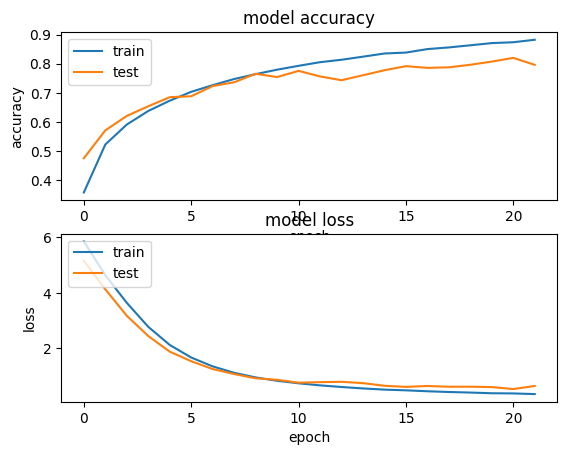

In [38]:
draw_training_curve(history)

In [24]:
model = tf.keras.models.load_model('res//res_epoch_18.h5')

In [ ]:
model.evaluate(test_it)

206/206 [==============================] - 16s 69ms/step - loss: 0.4996 - accuracy: 0.8274


[0.499632865190506, 0.8273906111717224]

In [26]:
from sklearn.preprocessing import normalize
size=SIZE
im_names = list(db['data'].keys())
num = 0
prediction_arr=[]
test_y = []
word_index = 0
for i in tqdm(range(0, len(im_names))):
    im = im_names[i]
    img, fonts, txts, charBBs, wordBBs = get_image_data(db, im)
    font_indx = 0 
    char_indx = 0
    for j in range(0, len(txts)):
        word_index+=1
        if(word_index%40==0): 
            curr_font = fonts[font_indx]
            test_x = [] 
            cropped = crop_and_save(img, wordBBs, j, size, curr_font, im, num, True)
            test_x.append(cropped)
            num+=1            
            for k in range(0, len(txts[j])):
                cropped = crop_and_save(img, charBBs, char_indx, size, curr_font, im, num, True)
                test_x.append(cropped)
                num+=1
                char_indx+=1
            test_x = np.asarray(test_x, dtype=np.float32)
            reses = model.predict(test_x, verbose=0)
            maxes = np.argmax(reses, axis=1)
            prediction = np.bincount(maxes)
            prediction = np.argwhere(prediction==prediction.max())
            if (len(prediction)>1):
                reses_n = normalize(reses, axis=1, norm='l1')
                maxes_n = np.argmax(reses_n, axis=1)
                prediction = np.bincount(maxes_n)
                prediction = np.argwhere(prediction==prediction.max())
                if(len(prediction)>1):
                    sum_p = reses.sum(axis=0)
                    prediction = sum_p.argmax()
            for k in range(0, len(txts[j])):
                test_y.append(font_to_num(fonts[font_indx]))
                if not np.isscalar(prediction):
                    prediction = prediction.item()
                prediction_arr.append(prediction)
        else:
            char_indx+=len(txts[j])
        font_indx += len(txts[j])



100%|██████████| 998/998 [00:28<00:00, 35.24it/s]


Check with arrays per image

In [27]:
print(len(prediction_arr))
print(len(test_y))

794
794


In [28]:

labels=['Alex Brush','Open Sans','Sansation','Titillium Web','Ubuntu Mono']
print(classification_report(test_y, prediction_arr, target_names=labels))

               precision    recall  f1-score   support

   Alex Brush       0.97      0.98      0.97       172
    Open Sans       0.85      0.86      0.85       159
    Sansation       0.86      0.93      0.89       185
Titillium Web       1.00      0.81      0.89       141
  Ubuntu Mono       0.94      1.00      0.97       137

     accuracy                           0.92       794
    macro avg       0.92      0.92      0.92       794
 weighted avg       0.92      0.92      0.92       794



In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              